# 4. 이미지 어디까지 우려볼까?

### Augmentation 적용 (1) 데이터 불러오기

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete6KY8C2/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete6KY8C2/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


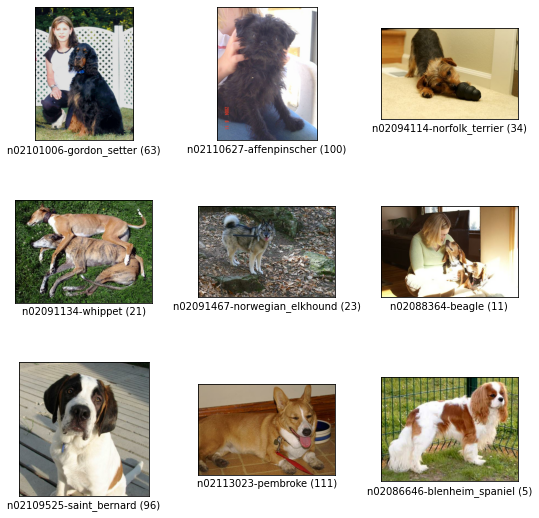

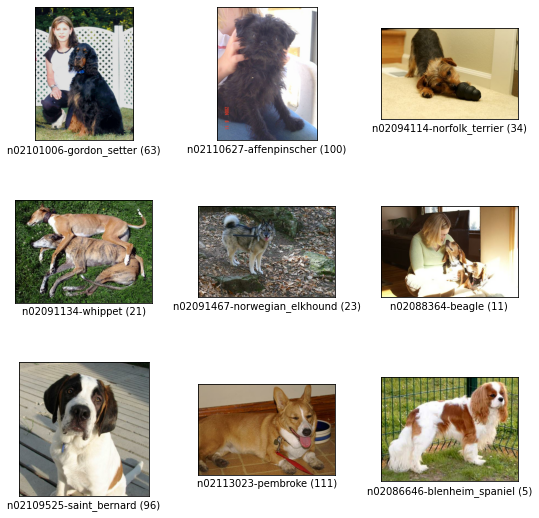

In [ ]:
tfds.show_examples(ds_train, ds_info)

### Augmentation 적용하기

텐서플로우 Random Augmentation API 사용하기

입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize합니다. 

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

 "flip"의 경우 좌우 대칭을 해줍니다. 

 "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 하겠습니다.

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

Random Augmentation 직접 구현하기

In [ ]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

비교 실험하기

In [ ]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 10

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 105s 117ms/step - loss: 2.2210 - accuracy: 0.4399 - val_loss: 3.1836 - val_accuracy: 0.2353
Epoch 2/20
750/750 [==============================] - 87s 115ms/step - loss: 0.7354 - accuracy: 0.7998 - val_loss: 1.1154 - val_accuracy: 0.6751
Epoch 3/20
750/750 [==============================] - 87s 115ms/step - loss: 0.2352 - accuracy: 0.9488 - val_loss: 0.9471 - val_accuracy: 0.7214
Epoch 4/20
750/750 [==============================] - 92s 122ms/step - loss: 0.0578 - accuracy: 0.9948 - val_loss: 0.8958 - val_accuracy: 0.7388
Epoch 5/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0216 - accuracy: 0.9993 - val_loss: 0.9005 - val_accuracy: 0.7418
Epoch 6/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0131 - accuracy: 0.9998 - val_loss: 0.9179 - val_accuracy: 0.7428
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.9260 - val_accuracy: 0.

In [ ]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 95s 119ms/step - loss: 2.2795 - accuracy: 0.4273 - val_loss: 3.2090 - val_accuracy: 0.2375
Epoch 2/20
750/750 [==============================] - 87s 116ms/step - loss: 0.9337 - accuracy: 0.7332 - val_loss: 1.1455 - val_accuracy: 0.6673
Epoch 3/20
750/750 [==============================] - 87s 116ms/step - loss: 0.4749 - accuracy: 0.8698 - val_loss: 1.0482 - val_accuracy: 0.6941
Epoch 4/20
750/750 [==============================] - 87s 116ms/step - loss: 0.2545 - accuracy: 0.9416 - val_loss: 1.0186 - val_accuracy: 0.7074
Epoch 5/20
750/750 [==============================] - 88s 117ms/step - loss: 0.1290 - accuracy: 0.9763 - val_loss: 0.9625 - val_accuracy: 0.7260
Epoch 6/20
750/750 [==============================] - 87s 117ms/step - loss: 0.0714 - accuracy: 0.9914 - val_loss: 0.9945 - val_accuracy: 0.7212
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0468 - accuracy: 0.9940 - val_loss: 1.1860 - val_accuracy: 0.6

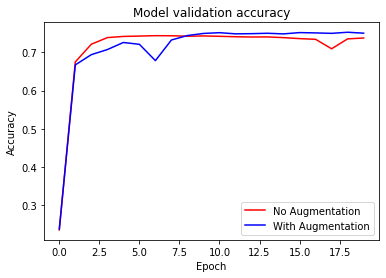

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='lower right')
plt.show()

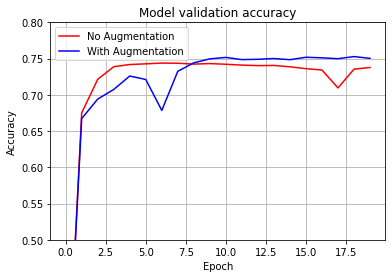

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

### Cutmix Augmentation

이미지 섞기

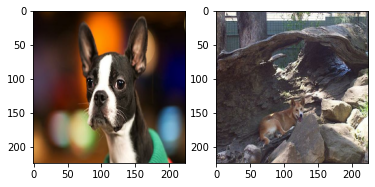

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(149, shape=(), dtype=int32)
y :  tf.Tensor(107, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


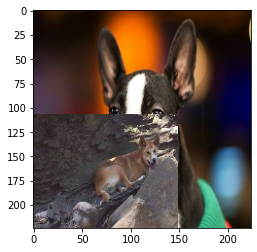

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

라벨 섞기

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.652563  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


## Mixup Augmentation

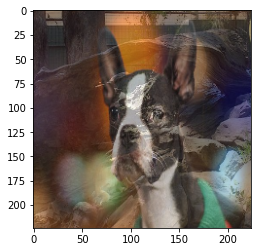

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.57783175 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


# CutMix 또는 Mixup 비교실험 하기

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
import urllib3
urllib3.disable_warnings()

# 사용할 데이터셋을 불러오기
(ds_train, ds_test), ds_info = tfds.load(name='stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True,
                                         )
print('train dataset :', len(ds_train))
print('test dataset :', len(ds_test))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteOLMHOH/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteOLMHOH/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
train dataset : 12000
test dataset : 8580


### 데이터셋 정보 확인

In [ ]:
# 데이터셋의 정보 확인
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

In [ ]:
# feature 정보 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [ ]:
# 데이터 개수 확인
print('train :', ds_info.splits['train'])
print('test  :', ds_info.splits['test'])

train : <tfds.core.SplitInfo num_examples=12000>
test  : <tfds.core.SplitInfo num_examples=8580>


In [ ]:
# 클래스의 개수 확인
num_classes = ds_info.features["label"].num_classes
print('class 개수 :', num_classes)

class 개수 : 120


In [ ]:
# 클래스의 이름 확인
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

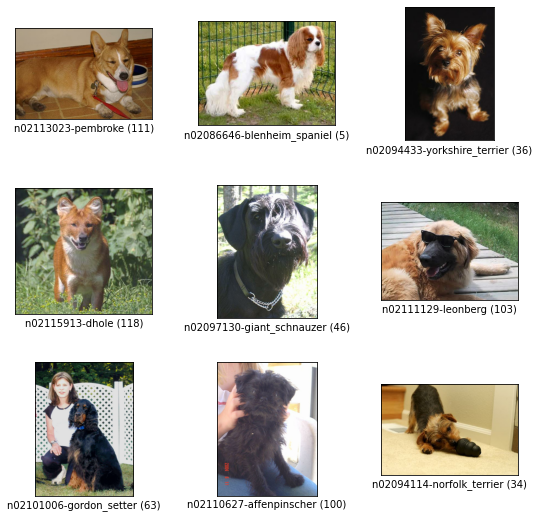

In [ ]:
# 불러온 데이터셋 시각화
fig = tfds.show_examples(ds_train, ds_info)

# 1. Augmentation을 적용한 데이터셋 만들기

### 데이터셋에 augmentation 적용하는 함수

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    # 위에서 만든 normalize 함수를 병렬로 map 하기
    ds = ds.map(
        normalize_and_resize_img,   # 기본적인 전처리 함수 적용
        num_parallel_calls=2        # 병렬처리할 때 가용할 CPU 코어 개수
    )
    # apply base augmentation
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    # split dataset into batches of batch_size    
    ds = ds.batch(batch_size)
    
    
    if not is_test and with_cutmix:      # apply CutMix augmentation
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:     # apply MixUP augmentation
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:                                # apply one-hot encoding
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

### Augmentation 적용하지 않은 데이터셋 생성

In [ ]:
# Augmentation 적용하지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_test_no_aug  = apply_normalize_on_dataset(ds_test, is_test=True)

### 기본 Augmentation 적용한 데이터셋 생성

In [ ]:
# 기본 Augmentation 적용한 데이터셋 생성
ds_train_base_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test_base_aug = apply_normalize_on_dataset(ds_test,  with_aug=True, is_test=True)

### Augmentation - CutMix

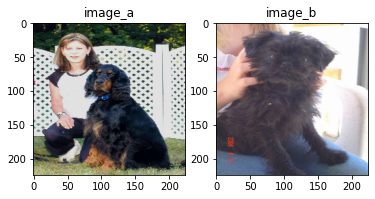

In [ ]:
# 데이터셋에서 이미지 2개를 가져오기 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):  
    # print(image.shape)  # (16, 224, 224, 3)
    # print(label.shape)  # (16,)
    
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.title("image_a")
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.title("image_b")
plt.imshow(image_b)

In [ ]:
# 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]   # width
    image_size_y = image_a.shape[0]   # height
    
    # get entire area of box
    x = tf.cast( tf.random.uniform([], minval=0, maxval=image_size_x), tf.int32)
    y = tf.cast( tf.random.uniform([], minval=0, maxval=image_size_y), tf.int32)

    # get width, height of box
    width  = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)), tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)        # get point starting in an area larger than 0       
    ya = tf.math.maximum(0, y-height//2)              
    xb = tf.math.minimum(image_size_x, x+width//2)   # get point ending in an area smaller than the image size
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(160, shape=(), dtype=int32) tf.Tensor(16, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(135, shape=(), dtype=int32)


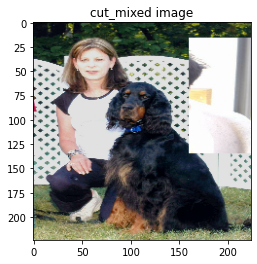

In [ ]:
# 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    # combine areas divided into five parts
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)

plt.title("cut_mixed image")
plt.imshow(mixed_img.numpy())

In [ ]:
# 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    # calculate the area ratio
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)    # a = 1 − λ

    # print(label_a.shape)
    # print(len(label_a.shape))
    
    # apply one-hot encoding
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    
    # 면적 비율만큼 라벨값 할당
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
print('cut_mixed label :', mixed_label)

cut_mixed label : tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.84821427 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.  

배치 단위의 cutmix() 함수

In [ ]:
# 배치 단위의 cutmix() 함수
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)  # 0 =< j < 16
        image_b = image[j]  
        label_b = label[j]
        
        # 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### CutMix Augmentation 적용한 데이터셋 생성

In [ ]:
# CutMix Augmentation 적용한 데이터셋 생성
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_cutmix=True) 
ds_test_cutmix_aug  = apply_normalize_on_dataset(ds_test,  with_cutmix=True, is_test=True)

### Augmentation - Mixup

mixup_label : 
 tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.84821427 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

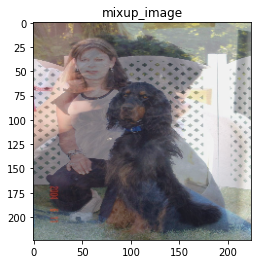

In [ ]:
# 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 함수
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    # 혼합 비율 선택
    a = tf.random.uniform([],0,1)
    
    # apply one-hot encoding of labels
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image = (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

plt.title('mixup_image')
plt.imshow(mixed_img.numpy())
print('mixup_label : \n', mixed_label)

In [ ]:
# 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 봅시다.
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### Mixup - Augmentation 적용한 데이터셋 생성

In [ ]:
# MixUp Augmentation 적용한 데이터셋 생성
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_mixup=True) 
ds_test_mixup_aug  = apply_normalize_on_dataset(ds_test,  with_mixup=True, is_test=True)

## 2. 모델 만들기

In [ ]:
# Augmentation을 적용하지 않은 데이터셋으로 학습시킬 ResNet
resnet50_no_aug = keras.models.Sequential([
    # ResNet50 중 imagenet에 훈련된 모델을 불러오기
    keras.applications.resnet.ResNet50(
        include_top=False,    # fully connected layer를 포함하지 않음
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    # fully connected layer 추가
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# 기본 Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_base_aug = keras.models.Sequential([
    # ResNet50 중 imagenet에 훈련된 모델을 불러오기
    keras.applications.resnet.ResNet50(
        include_top=False,    # fully connected layer를 포함하지 않음
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    # fully connected layer 추가
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
# CutMix Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_cutmix_aug = keras.models.Sequential([
    # ResNet50 중 imagenet에 훈련된 모델을 불러오기
    keras.applications.resnet.ResNet50(
        include_top=False,    # fully connected layer를 포함하지 않음
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    # fully connected layer 추가
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
# MixUp Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_mixup_aug = keras.models.Sequential([
    # ResNet50 중 imagenet에 훈련된 모델을 불러오기
    keras.applications.resnet.ResNet50(
        include_top=False,    # fully connected layer를 포함하지 않음
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    # fully connected layer 추가
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## 3. 모델 훈련하기

In [ ]:
# 하이퍼파라미터 설정
BATCH_SIZE = 16
EPOCH = 20  # 20  # Augmentation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2021)

### Augmentation 적용하지 않은 경우

In [ ]:
# Augmentation 적용하지 않은 경우
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# Augmentation 적용하지 않은 경우
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 106s 120ms/step - loss: 2.1844 - accuracy: 0.4514 - val_loss: 3.5715 - val_accuracy: 0.1765
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.6830 - accuracy: 0.8148 - val_loss: 1.0434 - val_accuracy: 0.6952
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1849 - accuracy: 0.9639 - val_loss: 0.9385 - val_accuracy: 0.7212
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0468 - accuracy: 0.9970 - val_loss: 0.9131 - val_accuracy: 0.7408
Epoch 5/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0205 - accuracy: 0.9998 - val_loss: 0.9212 - val_accuracy: 0.7418
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.9336 - val_accuracy: 0.7418
Epoch 7/20
750/750 [==============================] - 88s 118ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.9472 - val_a

### 기본 Augmentation 적용한 경우

In [ ]:
# 기본 Augmentation 적용한 경우
resnet50_base_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# 기본 Augmentation 적용한 경우
history_resnet50_base_aug = resnet50_base_aug.fit(
    ds_train_base_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_base_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 96s 119ms/step - loss: 2.2850 - accuracy: 0.4255 - val_loss: 2.9636 - val_accuracy: 0.2826
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 0.9245 - accuracy: 0.7312 - val_loss: 1.0967 - val_accuracy: 0.6722
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 0.4810 - accuracy: 0.8688 - val_loss: 1.0715 - val_accuracy: 0.6917
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2504 - accuracy: 0.9429 - val_loss: 0.9951 - val_accuracy: 0.7151
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1313 - accuracy: 0.9766 - val_loss: 1.0554 - val_accuracy: 0.7071
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0711 - accuracy: 0.9902 - val_loss: 0.9524 - val_accuracy: 0.7289
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0402 - accuracy: 0.9958 - val_loss: 0.9367 - val_ac

### CutMix Augmentation 적용한 경우

In [ ]:
# CutMix Augmentation 적용한 경우
resnet50_cutmix_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# CutMix Augmentation 적용한 경우
history_resnet50_cutmix_aug = resnet50_cutmix_aug.fit(
    ds_train_cutmix_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cutmix_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 103s 127ms/step - loss: 3.8426 - accuracy: 0.2044 - val_loss: 3.2944 - val_accuracy: 0.2156
Epoch 2/20
750/750 [==============================] - 90s 121ms/step - loss: 2.9449 - accuracy: 0.4330 - val_loss: 1.3611 - val_accuracy: 0.6206
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 2.6405 - accuracy: 0.5288 - val_loss: 1.3446 - val_accuracy: 0.6262
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 2.4149 - accuracy: 0.6015 - val_loss: 1.3042 - val_accuracy: 0.6413
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2634 - accuracy: 0.6501 - val_loss: 1.1620 - val_accuracy: 0.6776
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 2.1459 - accuracy: 0.6821 - val_loss: 1.2150 - val_accuracy: 0.6652
Epoch 7/20
750/750 [==============================] - 94s 126ms/step - loss: 2.0633 - accuracy: 0.7186 - val_loss: 1.2211 - val_a

### Mixup Augmentation 적용한 경우

In [ ]:
# MixUp Augmentation 적용한 경우
resnet50_mixup_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# MixUp Augmentation 적용한 경우
history_resnet50_mixup_aug = resnet50_mixup_aug.fit(
    ds_train_mixup_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_mixup_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 97s 121ms/step - loss: 3.7270 - accuracy: 0.2432 - val_loss: 5.0631 - val_accuracy: 0.0339
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 2.8570 - accuracy: 0.4864 - val_loss: 1.4928 - val_accuracy: 0.5896
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 2.5718 - accuracy: 0.5904 - val_loss: 1.2308 - val_accuracy: 0.6576
Epoch 4/20
750/750 [==============================] - 90s 121ms/step - loss: 2.3757 - accuracy: 0.6532 - val_loss: 1.2190 - val_accuracy: 0.6600
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2621 - accuracy: 0.7041 - val_loss: 1.3008 - val_accuracy: 0.6483
Epoch 6/20
750/750 [==============================] - 95s 126ms/step - loss: 2.1610 - accuracy: 0.7475 - val_loss: 1.2141 - val_accuracy: 0.6678
Epoch 7/20
750/750 [==============================] - 92s 122ms/step - loss: 2.0526 - accuracy: 0.7828 - val_loss: 1.2339 - val_ac

# 훈련 과정 시각화하기

### No & Base Augmentation 경우

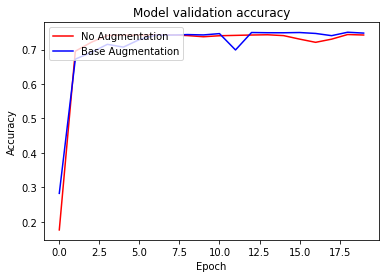

In [ ]:
# 훈련 과정을 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Base Augmentation'], loc='upper left')
plt.show()

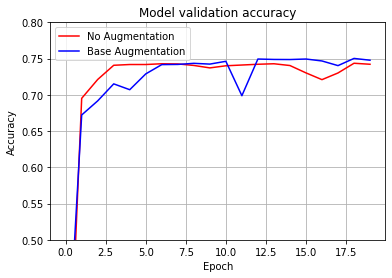

In [ ]:
# 조금 더 확대해 살펴봅시다.
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Base Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # (0.72, 0.76) : 20 epoch
plt.show()

### Base & CutMix Augmentation 적용한 경우

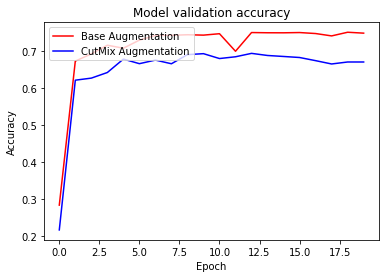

In [ ]:
# 훈련 과정을 시각화
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'CutMix Augmentation'], loc='upper left')
plt.show()

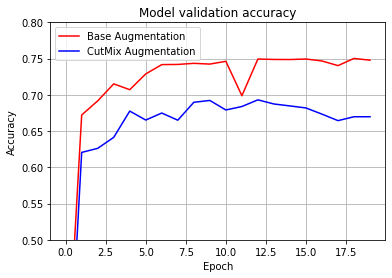

In [ ]:
# 조금 더 확대해 살펴봅시다.
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'CutMix Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # (0.72, 0.76) : 20 epoch
plt.show()

### Base & Mixup Augmentation 적용한 경우

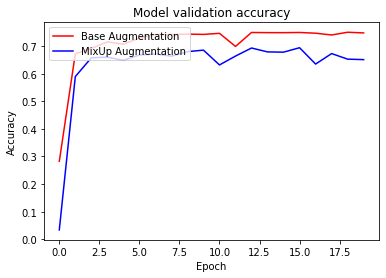

In [ ]:
# 훈련 과정을 시각화
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'MixUp Augmentation'], loc='upper left')
plt.show()

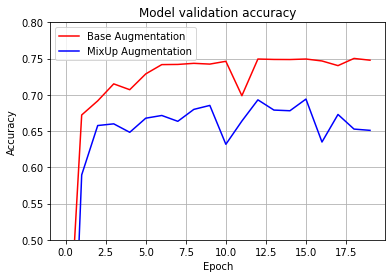

In [ ]:
# 조금 더 확대해 살펴봅시다.
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'MixUp Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # (0.72, 0.76) : 20 epoch
plt.show()

# 5. Augmentation에 의한 모델 성능 비교

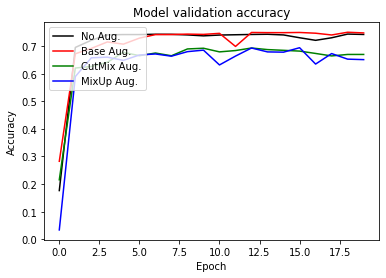

In [ ]:
# 훈련 과정을 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'k')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug.', 'Base Aug.', 'CutMix Aug.', 'MixUp Aug.'], loc='upper left')
plt.show()

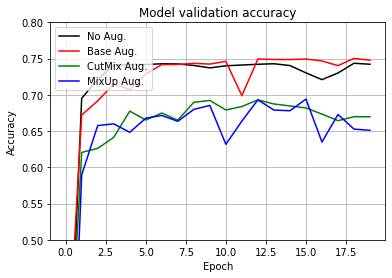

In [ ]:
# 조금 더 확대해 살펴봅시다.
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'k')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug.', 'Base Aug.', 'CutMix Aug.', 'MixUp Aug.'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # (0.72, 0.76) : 20 epoch
plt.show()

회고

1. Augmentation이 있고 없는 경우에 데이터는 거의 유사하게 나왔다.
2. CutMix Augmentation을 하거나 MixUp 을 하는 경우는 Augmentation이 없는 경우와의 차이가 그래프로 잘 보여주고 있다.
3. CutMix이나 Mixup는 기존 이미지를 많이 변화를 주므로 이 이미지로 훈련된 데이터는 정확도가 낮게 나오는 것으로 생각된다.
4. 훈련할 데이터가 부족한 경우 이런 다양한 방법으로 데이터를 생성할 수 있는 것 같다.